<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/modelisation/3_regression.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/modelisation/3_regression.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/modelisation/3_regression.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&in
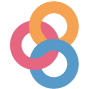

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/modelisation/3_regression.qmd")

Le précédent chapitre visait à proposer un premier modèle pour comprendre
les comtés où le parti Républicain l'emporte. La variable d'intérêt étant
bimodale (victoire ou défaite), on était dans le cadre d'un modèle de 
classification.

Maintenant, sur les mêmes données, on va proposer un modèle de régression
pour expliquer le score du parti Républicain. La variable est donc continue.
Nous ignorerons le fait que ses bornes se trouvent entre 0 et 100 et donc 
qu'il faudrait, pour être rigoureux, transformer l'échelle afin d'avoir 
des données dans cet intervalle. 

Ce chapitre utilise toujours le même jeu de données, présenté dans l'[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).


In [2]:
#| include: false
#| echo: true

#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

ERROR 1: PROJ: proj_create_from_database: Open of /miniconda/envs/python-ENSAE/share/proj failed


# Principe général

Le principe général de la régression consiste à trouver une loi $h_\theta(X)$
telle que


$$
h_\theta(X) = \mathbb{E}_\theta(Y|X)
$$

Cette formalisation est extrêmement généraliste et ne se restreint d'ailleurs
par à la régression linéaire. 

En économétrie, la régression offre une alternative aux méthodes de maximum
de vraisemblance et aux méthodes des moments. La régression est un ensemble 
très vaste de méthodes, selon la famille de modèles
(paramétriques, non paramétriques, etc.) et la structure de modèles. 


## La régression linéaire

C'est la manière la plus simple de représenter la loi $h_\theta(X)$ comme 
combinaison linéaire de variables $X$ et de paramètres $\theta$. Dans ce
cas, 


$$
\mathbb{E}_\theta(Y|X) = X\beta
$$



Cette relation est encore, sous cette formulation, théorique. Il convient 
de l'estimer à partir des données observées $y$. La méthode des moindres
carrés consiste à minimiser l'erreur quadratique entre la prédiction et 
les données observées (ce qui explique qu'on puisse voir la régression comme
un problème de *Machine Learning*). En toute généralité, la méthode des
moindres carrés consiste à trouver l'ensemble de paramètres $\theta$ 
tel que


$$
\theta = \arg \min_{\theta \in \Theta} \mathbb{E}\bigg[ \left( y - h_\theta(X) \right)^2 \bigg]
$$


Ce qui, dans le cadre de la régression linéaire, s'exprime de la manière suivante:


$$
\beta = \arg\min \mathbb{E}\bigg[ \left( y - X\beta \right)^2 \bigg]
$$


Lorsqu'on amène le modèle théorique ($\mathbb{E}_\theta(Y|X) = X\beta$) aux données,
on formalise le modèle de la manière suivante:


$$
Y = X\beta + \epsilon
$$


Avec une certaine distribution du bruit $\epsilon$ qui dépend
des hypothèses faites. Par exemple, avec des 
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ i.i.d., l'estimateur $\beta$ obtenu
est équivalent à celui du Maximum de Vraisemblance dont la théorie asymptotique
nous assure l'absence de biais, la variance minimale (borne de Cramer-Rao).

{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 1a : Régression linéaire avec scikit [parcours data-science]**

Cet exercice vise à illustrer la manière d'effectuer une régression linéaire avec `scikit`.
Dans ce domaine,
`statsmodels` est nettement plus complet, ce que montrera l'exercice suivant.
L'intérêt principal de faire 
des régressions avec `scikit` est de pouvoir comparer les résultats d'une régression linéaire
avec d'autres modèles de régression. Cependant, le chapitre sur les 
pipelines montrera qu'on peut très bien insérer, avec quelques efforts
de programmation orientée objet, une régression `statsmodels` dans 
un pipeline `scikit`. 

L'objectif est d'expliquer le score des Républicains en fonction de quelques
variables. Contrairement au chapitre précédent, où on se focalisait sur
un résultat binaire (victoire/défaite des Républicains), cette
fois on va chercher à modéliser directement le score des Républicains. 


In [3]:
# packages utiles
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

1. A partir de quelques variables, par exemple, *'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"*, expliquer la variable `per_gop` à l'aide d'un échantillon d'entraînement `X_train` constitué au préalable.

:warning: utiliser la variable `Median_Household_Income_2019`
en `log` sinon son échelle risque d'écraser tout effet.


In [4]:
#| include: false

# 1. Régression linéaire de per_gop sur différentes variables explicatives
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df2 = votes[["per_gop"] + xvars]
df2['log_income'] = np.log(df2["Median_Household_Income_2019"])
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Median_Household_Income_2019","per_gop"], axis = 1),
    100*df2[['per_gop']].values.ravel(), test_size=0.2, random_state=0
)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
#y_pred[:10]

/tmp/ipykernel_1440/1125558845.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2. Afficher les valeurs des coefficients, constante comprise


In [5]:
#| include: false
#| echo: false

#2. Afficher les valeurs des coefficients
print(ols.intercept_, ols.coef_)

38.72457422624494 [-3.44264194 -0.47323213 -1.40067009  7.06268493]


3. Evaluer la pertinence du modèle avec le $R^2$ et la qualité du fit avec le MSE.


In [6]:
#| include: false
#| echo: false

# 3. Evaluer la pertinence du modèle

rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
rsq = sklearn.metrics.r2_score(y_test, y_pred) 

print('Mean squared error: %.2f'
      % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % rsq)

Mean squared error: 12.56
Coefficient of determination: 0.41


4. Représenter un nuage de points des valeurs observées
et des erreurs de prédiction. Observez-vous
un problème de spécification ?


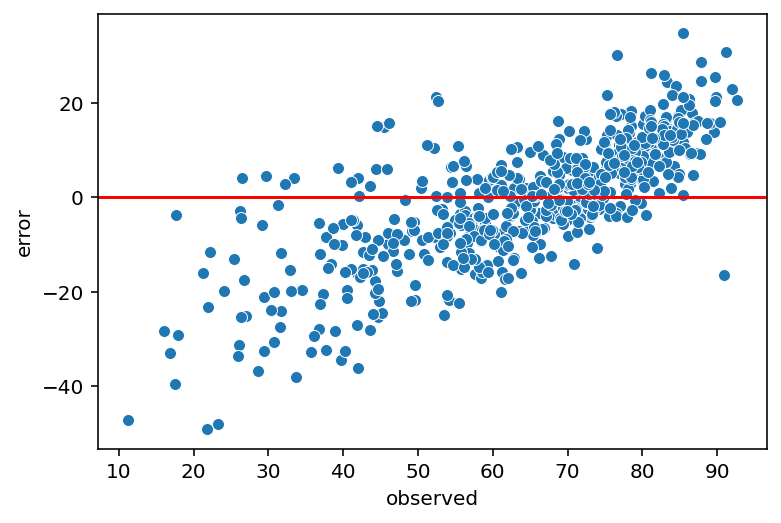

In [7]:
#| include: false
#| echo: false

#4. Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": y_pred, "observed": y_test,
                       "error": y_test - y_pred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "error")
g.axhline(0, color = "red")

# La répartition des erreurs n'est clairement pas 
# aléatoire en fonction de $X$.
# Le modèle souffre
# donc d'un problème de spécification. 

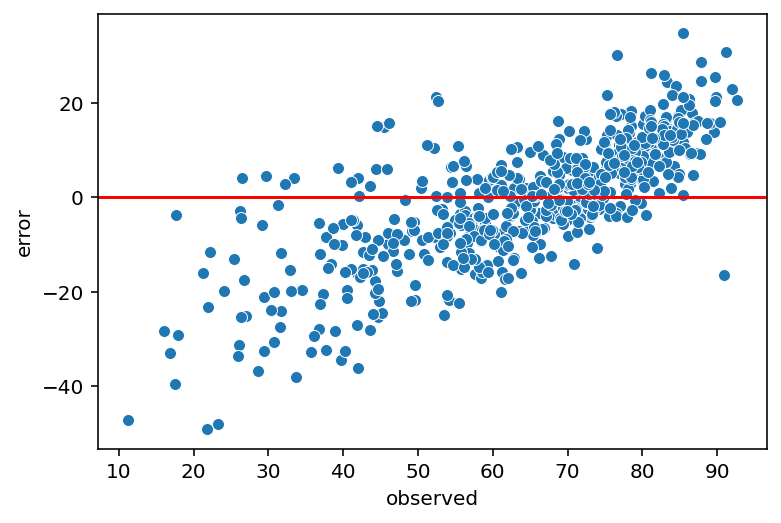

In [8]:
g.figure.get_figure()

{{% /box %}}


{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 1b : Régression linéaire avec scikit [parcours économie]**

Cet exercice vise à illustrer la manière d'effectuer une régression linéaire avec `statsmodels` qui offre une interface proche de celle de `R`.

L'objectif est d'expliquer le score des Républicains en fonction de quelques
variables


In [9]:
# packages utiles
import statsmodels.api as sm
import statsmodels.formula.api as smf

1. A partir de quelques variables, par exemple, *'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"*, expliquer la variable `per_gop`. :warning: utiliser la variable `Median_Household_Income_2019`
en `log` sinon son échelle risque d'écraser tout effet.


In [10]:
#| include: false
#| echo: false

# 1. Régression linéaire de per_gop sur différentes variables explicatives
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df2 = votes[["per_gop"] + xvars]
df2['log_income'] = np.log(df2["Median_Household_Income_2019"])
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

X = sm.add_constant(df2.drop(["Median_Household_Income_2019","per_gop"], axis = 1))
results = sm.OLS(df2[['per_gop']], X).fit()

/tmp/ipykernel_1440/1814355989.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2. Afficher un tableau de régression.


In [11]:
#| include: false
#| echo: false

# 2. Afficher le tableau de régression
print(results.summary())
# html_snippet = results.summary().as_html()

                            OLS Regression Results                            
Dep. Variable:                per_gop   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     608.7
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        12:30:14   Log-Likelihood:                 2172.5
No. Observations:                3107   AIC:                            -4335.
Df Residuals:                    3102   BIC:                            -4305.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

3. Evaluer la pertinence du modèle avec le R^2.


In [12]:
#| include: false
#| echo: false

# 3. Calcul du R^2
print("R2: ", results.rsquared)

R2:  0.4397513692296381


4. Utiliser l'API `formula` pour régresser le score des républicains en fonction de la variable `Unemployment_rate_2019`, de `Unemployment_rate_2019` au carré et du log de 
`Median_Household_Income_2019`.


In [13]:
#| include: false
#| echo: false

# 4. Nouvelle régression avec l'API formula
results = smf.ols('per_gop ~ Unemployment_rate_2019 + I(Unemployment_rate_2019**2) + np.log(Median_Household_Income_2019)', data=df2).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                per_gop   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     133.8
Date:                Wed, 25 May 2022   Prob (F-statistic):           1.55e-81
Time:                        12:30:14   Log-Likelihood:                 1461.5
No. Observations:                3107   AIC:                            -2915.
Df Residuals:                    3103   BIC:                            -2891.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


{{% /box %}}

{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
Pour sortir une belle table pour un rapport sous $\LaTeX$, il est possible d'utiliser
la méthode [`Summary.as_latex`](https://www.statsmodels.org/devel/generated/statsmodels.iolib.summary.Summary.as_latex.html#statsmodels.iolib.summary.Summary.as_latex). Pour un rapport HTML, on utilisera [`Summary.as_html`](https://www.statsmodels.org/devel/generated/statsmodels.iolib.summary.Summary.as_latex.html#statsmodels.iolib.summary.Summary.as_latex)
{{% /box %}}


{{% box status="note" title="Note" icon="fa fa-comment" %}}
Les utilisateurs de `R` retrouveront des éléments très familiers avec `statsmodels`,
notamment la possibilité d'utiliser une formule pour définir une régression.
La philosophie de `statsmodels` est similaire à celle qui a influé sur la construction
des packages `stats` et `MASS` de `R`: offrir une librairie généraliste, proposant
une large gamme de modèles. Néanmoins, `statsmodels` bénéficie de sa jeunesse
par rapport aux packages `R`. Depuis les années 1990, les packages `R` visant 
à proposer des fonctionalités manquantes dans `stats` et `MASS` se sont
multipliés alors que `statsmodels`, enfant des années 2010, n'a eu qu'à
proposer un cadre général (les *generalized estimating equations*) pour
englober ces modèles.
{{% /box %}}

## La régression logistique

Ce modèle s'applique à une distribution binaire.
Dans ce cas, $\mathbb{E}\_{\theta}(Y|X) = \mathbb{P}\_{\theta}(Y = 1|X)$.
La régression logistique peut être vue comme un modèle linéaire en probabilité:


$$
\text{logit}\bigg(\mathbb{E}\_{\theta}(Y|X)\bigg) = \text{logit}\bigg(\mathbb{P}\_{\theta}(Y = 1|X)\bigg) = X\beta
$$


La fonction $\text{logit}$ est $]0,1[ \to \mathbb{R}: p \mapsto \log(\frac{p}{1-p})$.

Elle permet ainsi de transformer une probabilité dans $\mathbb{R}$.
Sa fonction réciproque est la sigmoïde ($\frac{1}{1 + e^{-x}}$),
objet central du *Deep Learning*.

Il convient de noter que les probabilités ne sont pas observées, c'est l'*outcome*
binaire (0/1) qui l'est. Cela amène à voir la régression logistique de deux
manières différentes :

* En économétrie, on s'intéresse au modèle latent qui détermine le choix de
l'outcome. Par exemple, si on observe les choix de participer ou non au marché
du travail, on va modéliser les facteurs déterminant ce choix ;
* En *Machine Learning*, le modèle latent n'est nécessaire que pour classifier
dans la bonne catégorie les observations

L'estimation des paramètres $\beta$ peut se faire par maximum de vraisemblance
ou par régression, les deux solutions sont équivalentes sous certaines
hypothèses. 


{{% box status="note" title="Note" icon="fa fa-comment" %}}
Par défaut, `scikit` applique une régularisation pour pénaliser les modèles
peu parcimonieux (comportement différent
de celui de `statsmodels`). Ce comportement par défaut est à garder à l'esprit
si l'objectif n'est pas de faire de la prédiction. 
{{% /box %}}


{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 2a : Régression logistique [data-scientists]**

Avec `scikit`, en utilisant échantillons d'apprentissage et d'estimation :


In [14]:
# packages utiles
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

1. Evaluer l'effet des variables déjà utilisées sur la probabilité des Républicains
de gagner. Affichez la valeur des coefficients.


In [15]:
#| include: false
#| echo: false

#1. Modèle logit avec les mêmes variables que précédemment
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df2 = votes[["per_gop"] + xvars]
df2['log_income'] = np.log(df2["Median_Household_Income_2019"])
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

df2['y'] = (df2['per_gop']>0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Median_Household_Income_2019","y"], axis = 1),
    1*df2[['y']].values.ravel(), test_size=0.2, random_state=0
)

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_pred[:10]
print(clf.intercept_, clf.coef_)
# Lino : KA a fait un début de corrigé rapidos : à vérifier

[-14.67252665] [[14.97958856 -0.09357842 -0.0688799  -0.10031329  1.04836814]]


/tmp/ipykernel_1440/1378607806.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2. Déduire une matrice de confusion et 
une mesure de qualité du modèle.


/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



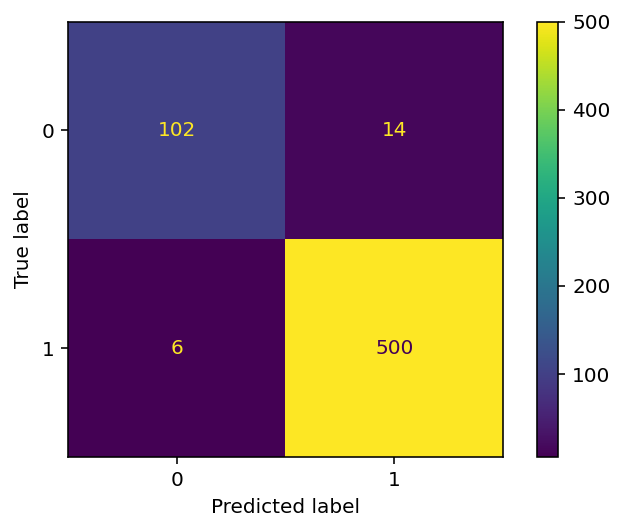

In [16]:
#| include: false
#| echo: false

# 2. Matrice de confusion
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

#print(sc_accuracy)
#print(sc_f1)
#print(sc_recall)
#print(sc_precision)

# Lino : KA a fait un début de corrigé rapidos : à vérifier

3. Supprimer la régularisation grâce au paramètre `penalty`. Quel effet sur les paramètres estimés ?


In [17]:
#| include: false
#| echo: false

#3. Supprimer la régularisation
clf2 = LogisticRegression(penalty='none').fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
print(clf2.intercept_, clf2.coef_)
# Les coefficients sont complètement différents

# Lino : KA a fait un début de corrigé rapidos : à vérifier

[-8314.41041914] [[1.59474611e+04 7.09591795e+00 1.67681016e+00 2.46307896e-02
  2.54867097e+01]]


{{% /box %}}


{{% box status="exercise" title="Exercice" icon="fas fa-pencil-alt" %}}

**Exercice 2b : Régression logistique [économistes]**


In [18]:
# packages utiles
from scipy import stats

En utilisant échantillons d'apprentissage et d'estimation :

1. Evaluer l'effet des variables déjà utilisées sur la probabilité des Républicains
de gagner.


In [19]:
#| include: false
#| echo: false

#1. Modèle logit avec les mêmes variables que précédemment
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df2 = votes[["per_gop"] + xvars]
df2['log_income'] = np.log(df2["Median_Household_Income_2019"])
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

df2['y'] = (df2['per_gop']>0.5).astype(int)

mylogit = smf.logit(formula = 'y ~ Unemployment_rate_2019 + I(Unemployment_rate_2019**2) + np.log(Median_Household_Income_2019)', data=df2[df2['Median_Household_Income_2019']>0]).fit()
print(mylogit.summary())

Optimization terminated successfully.
         Current function value: 0.452194
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3107
Model:                          Logit   Df Residuals:                     3103
Method:                           MLE   Df Model:                            3
Date:                Wed, 25 May 2022   Pseudo R-squ.:                 0.04442
Time:                        12:30:15   Log-Likelihood:                -1405.0
converged:                       True   LL-Null:                       -1470.3
Covariance Type:            nonrobust   LLR p-value:                 3.977e-28
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               28.5676      2.5

/tmp/ipykernel_1440/2480865718.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2. Faire un test de ratio de vraisemblance concernant l'inclusion de la variable de (log)-revenu.


In [20]:
#| include: false
#| echo: false

#2. Faire un test de ratio de vraisemblance 
logit_h0 = smf.logit(formula = 'y ~ Unemployment_rate_2019 + I(Unemployment_rate_2019**2)', data=df2[df2['Median_Household_Income_2019']>0]).fit()
# print(logit_h0.summary())

lr = -2*(mylogit.llf - logit_h0.llf)
lrdf = (logit_h0.df_resid - mylogit.df_resid)

lr_pvalue = stats.chi2.sf(lr, df=lrdf)
#print(lr_pvalue)

# La pvalue du test de maximum de ratio
# de vraisemblance étant proche de  1,
# cela signifie que la variable log revenu ajoute,
# presque à coup sûr, de l'information au modèle. 

Optimization terminated successfully.
         Current function value: 0.470844
         Iterations 5


{{% /box %}}

{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
La statistique du test est:

$$
LR = -2\log\bigg(\frac{\mathcal{L}_{\theta}}{\mathcal{L}_{\theta_0}}\bigg) = -2(\mathcal{l}_{\theta} - \mathcal{l}_{\theta_0})
$$

{{% /box %}}


<!-- ## Modèles linéaires généralisés -->

<!-- TO BE COMPLETED -->

<!-- ## Autres modèles de Machine Learning -->

<!-- TO BE COMPLETED -->

<!-- ## Tests d'hypothèses -->
